<a href="https://colab.research.google.com/github/clistenes-fernandes/sentiment-analysis/blob/master/Sentiment_Analysis_With_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Importing The Necessary Libraries

In [0]:
import numpy as np
import math
import re # regular expression
import pandas as pd
from bs4 import BeautifulSoup #Text pre-processing
from google.colab import drive
import zipfile
import seaborn as sns #Data visualization
import string
import spacy as sp
import random
import matplotlib.pyplot as plt

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0'

In [0]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Section 2: Pre processing

###Dataset upload

In [4]:
#get the database from Drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Extract the file in the root folder of Colab
path = '/content/drive/My Drive/trainingandtestdata.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [0]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [0]:
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', header=None,
                         names=cols, engine='python', encoding='latin1')

In [8]:
train_data.shape

(1600000, 6)

In [9]:
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
train_data.sentiment.unique()

array([0, 4])

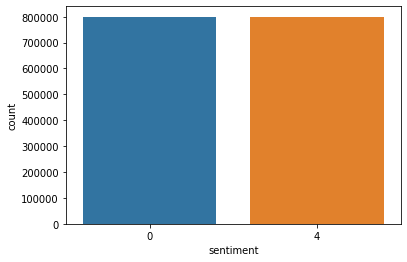

In [11]:
sns.countplot(train_data.sentiment)

In [0]:
test_data = pd.read_csv('/content/trainingandtestdata/test.csv',
                        header=None,
                        names=cols,
                        engine='python',
                        encoding='latin1')

In [13]:
test_data.shape

(498, 6)

In [14]:
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [15]:
test_data.sentiment.unique()

array([4, 0, 2])

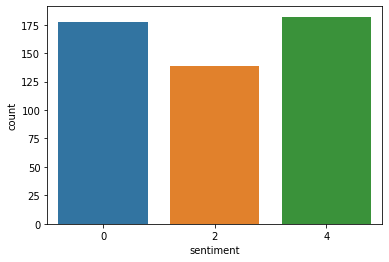

In [16]:
sns.countplot(test_data.sentiment)

### Cleaning

In [0]:
data = train_data

In [0]:
data.drop(['id', 'date', 'query', 'user'], axis=1, inplace=True)

In [19]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [0]:
x = data.iloc[:, 1].values

In [21]:
x

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [22]:
x.shape

(1600000,)

In [23]:
type(x)

numpy.ndarray

In [24]:
y = data.iloc[:, 0].values
y

array([0, 0, 0, ..., 4, 4, 4])

Because of the size of the dataset, it'd take some hours to train. Will only be used 15% of the dataset. 

In [0]:
from sklearn.model_selection import train_test_split
x, _, y, _ = train_test_split(x, y, test_size=0.85, stratify = y)# stratify in this case is used to split the same quantity of positive and negative classes

In [26]:
x.shape

(240000,)

In [27]:
y.shape

(240000,)

In [28]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4]), array([120000, 120000]))

In [0]:
#remove stop words (words that may be removed without affecting the classification of the sentiment), using the "spacy" library
nlp = sp.load('en')
stop_words = sp.lang.en.STOP_WORDS

In [0]:
def stop_words_removal(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []

  for token in document:
    words.append(token.text)
  
  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])
  return words

In [0]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)#removing the username
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)#removing the URL
  tweet = re.sub(r"[^A-Za-z.!?]", ' ', tweet)#removing special characters
  tweet = re.sub(r" +", ' ', tweet)
  tweet = stop_words_removal(tweet)
  return tweet.strip()

In [0]:
text = "@switchfoot http://twitpic.com/2ylzl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"

In [34]:
text = clean_tweets(text)
text

'awww s bummer shoulda got david carr day d'

In [0]:
data_clean = [clean_tweets(tweet) for tweet in x]

In [36]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean)-1)])

aww
momma said life like box chocoate know
anya hey following bettie
knows life sucks people hte coffee shop telling works
oh going slowly running gerys anatomy online mean nap time s
... eating chicken terriyaki watching muse videos volume
knew guy guangzhou u hair died blond nicknamed johnny straker ufo looked kinda cool nice guy
favorite pictures gavin took
went chuck e cheeses
wants


In [0]:
data_labels = y

In [38]:
data_labels[data_labels == 4] = 1
data_labels

array([1, 0, 1, ..., 1, 1, 0])

In [39]:
np.unique(data_labels)

array([0, 1])

### Tokenization

In [0]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16, )

In [41]:
tokenizer.vocab_size

52828

In [42]:
ids = tokenizer.encode('i am happy')
ids

[273, 3896, 369]

In [44]:
phrase = tokenizer.decode(ids)
phrase

'i am happy'

In [0]:
#create a list of sentence tokens
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [46]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs)-1)])

[8926, 352, 2344, 871, 12, 632]
[17268, 24149, 62, 694, 1758]
[835, 11, 711, 193, 43]
[628, 1306, 2, 4264, 3334]
[12, 16, 39280, 35, 804]
[528, 24050, 52137, 736]
[32942, 27216, 3632, 224, 3678, 2649, 14, 170]
[328, 881, 1119, 6901, 77, 60, 6310]
[22670, 30, 56, 2200, 4, 56, 37944, 15]
[304, 3, 7001, 24644, 599, 1454, 144, 24, 33867, 15]


### Padding

Pad the sentences, so all get the same size

In [47]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

55

In [0]:
#pad the sentences with 0s on the right
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs, value=0, padding='post', maxlen=max_len)

In [49]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs)-1)])

[   40   302   940 36847  3226 23954   161  1482  1770     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
[ 63 199 334   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]
[   2   10 1209  557   10  360    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
[13807 14155  6952 44834 23533     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0 

### Split the dataset into train and test

In [0]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs, data_labels, test_size=0.3, stratify = data_labels)

In [51]:
train_inputs[0]

array([   63,   600,   598,    21,   913,     4,   309,  3327, 10323,
           4,   418,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [52]:
train_inputs.shape

(168000, 55)

In [53]:
train_labels.shape

(168000,)

In [54]:
test_inputs.shape

(72000, 55)

In [55]:
test_labels.shape

(72000,)

# Section 3: Building the Model

In [0]:
class DCNN(tf.keras.Model):
  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    '''
    :param vocab_size: Size of the vocabulary
    :param emb_dim: Dimension of the embedding -- emb_dim=128
    :param nb_filters: Number of convolutional -- filters nb_filters=50
    :param ffn_units: Number of Feedforward Networks units -- ffn_units=512
    :param nb_classes: Number of classes -- nb_classes=2
    :param droupout_rate: Dropout rate, helps to avoid overfitting -- dropout_rate=0.1
    :param training: training=False
    :param name: name="dcnn"
    '''
    super(DCNN, self).__init__(name=name)

    #Convolution Layers
    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    #Dense Network
    self.dense_1 = layers.Dense(units = ffn_units)

    self.dropout = layers.Dropout(rate = droupout_rate)
    if nb_classes == 2:
      #we want, in this case, return only one correct classification
      self.last_dense = layers.Dense(units=1, activation='sigmoid')
    else:
      #Softmax activation function returns the probability of all classes 
      self.last_dense = layers.Dense(units=nb_classes, activation='softmax')

    
  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)

    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)

    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis=-1)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Section 4: Training

### Parameters Setup

Parameters were tested in advance and performed the best results among the tested.

In [0]:
vocab_size = tokenizer.vocab_size
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size=64
nb_classes = len(set(train_labels))#set function returns the number of unique values in train_labels
dropout_rate = 0.2
nb_epochs = 10

### Training

In [0]:
dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim,
            nb_filters=nb_filters, ffn_units=ffn_units,
            nb_classes=nb_classes, dropout_rate=dropout_rate)

In [0]:
if nb_classes == 2:
  dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
checkpoint_path = '/content/drive/My Drive/'
ckpt = tf.train.Checkpoint(dcnn=dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt.latest_checkpoint)
  print('Latest checkpoint restored')

In [68]:
history = dcnn.fit(train_inputs, 
                   train_labels,
                   batch_size=batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split= 0.10)
ckpt_manager.save()

Train on 151200 samples, validate on 16800 samples
Epoch 1/10
151200/151200 [==============================] - 249s 2ms/sample - loss: 0.5065 - accuracy: 0.7488 - val_loss: 0.4807 - val_accuracy: 0.7672
Epoch 2/10
151200/151200 [==============================] - 247s 2ms/sample - loss: 0.3643 - accuracy: 0.8415 - val_loss: 0.5273 - val_accuracy: 0.7535
Epoch 3/10
151200/151200 [==============================] - 247s 2ms/sample - loss: 0.1824 - accuracy: 0.9271 - val_loss: 0.6903 - val_accuracy: 0.7386
Epoch 4/10
151200/151200 [==============================] - 247s 2ms/sample - loss: 0.0907 - accuracy: 0.9647 - val_loss: 0.8811 - val_accuracy: 0.7244
Epoch 5/10
151200/151200 [==============================] - 247s 2ms/sample - loss: 0.0617 - accuracy: 0.9751 - val_loss: 1.0305 - val_accuracy: 0.7266
Epoch 6/10
151200/151200 [==============================] - 246s 2ms/sample - loss: 0.0484 - accuracy: 0.9803 - val_loss: 1.2177 - val_accuracy: 0.7199
Epoch 7/10
151200/151200 [===========

'/content/drive/My Drive/ckpt-1'

# Section 5: Evaluate The Model

### Evaluation

In [69]:
results = dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

72000/72000 [==============================] - 3s 46us/sample - loss: 1.5431 - accuracy: 0.7085
[1.5431271460851033, 0.7085139]


In [0]:
y_pred_test = dcnn.predict(test_inputs)

In [71]:
y_pred_test

array([[8.6388546e-01],
       [3.9842868e-01],
       [3.7376087e-06],
       ...,
       [2.6155548e-02],
       [9.9999583e-01],
       [9.5445353e-01]], dtype=float32)

In [0]:
y_pred_test = (y_pred_test > 0.5)

In [73]:
y_pred_test

array([[ True],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [ True]])

In [74]:
test_labels

array([1, 0, 0, ..., 0, 1, 0])

In [75]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[27736,  8264],
       [12723, 23277]])

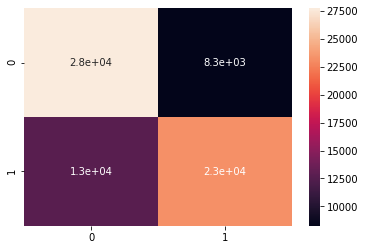

In [77]:
# Confusion Matrix
sns.heatmap(cm, annot=True)

In [79]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

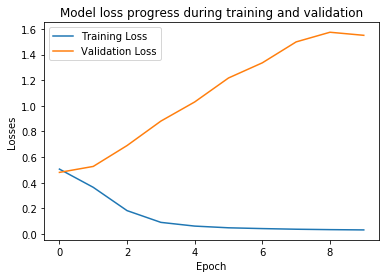

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training Loss', 'Validation Loss'])

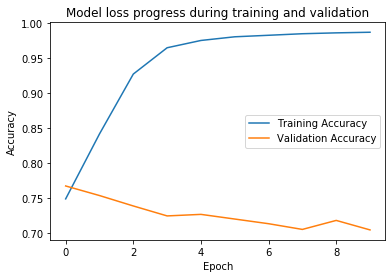

In [81]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

### Predictions

In [86]:
positive_text = 'you are so funny'
positive_text = tokenizer.encode(positive_text)
positive_text

[4798, 11575, 3241, 743]

In [87]:
dcnn(np.array([positive_text]), training=False).numpy()

array([[0.99999917]], dtype=float32)

In [88]:
negative_text = 'i hate you'
negative_text = tokenizer.encode(negative_text)
negative_text

[273, 63, 3231]

In [93]:
dcnn(np.array([negative_text]), training=False).numpy()

array([[5.8347296e-06]], dtype=float32)